# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


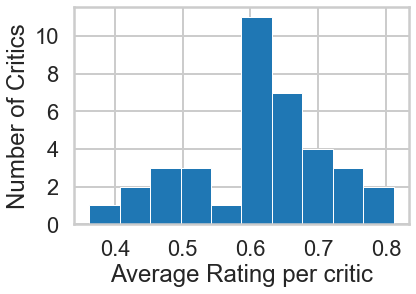

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

Response:
The range of movie rating is from 0.0 to 1.0. So, it is natural to expect that the average movie rating of a critic would be around 0.5 since 

The rating is relative, not absolute, i.e. a movie being reviewed is compared against the previous movies.
This means that it is expected that average movie ratings would be spread following a normal distribution and critics' average rating would follow the same with half the movies being rated as bad (rotten), i.e. rating < 0.5 and the other half being rated as good (fresh) > 0.5
The above histogram shows the distribution of ratings by people who watch a lot of movies, i.e. these critics have reviewed more than a 100 movies. This chart shows that around 80% of these critics rate more than half the movies they watch as fresh. This probable causes for this behavior are

they really love watching movies and hence they are biased to rate more movies as fresh
they watch more movies that are recommended by others to be good
To check this further, we can look at the distribution of average movie rating of critics varying the number of movies they have reviewed. See the charts below, it shows the distribution of average ratings by critics who have rated at least a certain number (100, 50, 25,10). As expected, as the cut-off of 'number of movies reviewed' is lowered, the distribution starts to follows a normal distribution with mean around 0.5. 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [9]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

As we can see from the above accuracy scores on testing and training data, there is a lot of overfit. So, this classifier needs to be tweaked to improve accuracy

In [11]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(X,y)
clf = MultinomialNB()
clf.fit(X_train, y_train)
print(clf.predict(X_test[2:5]))
y_test[2:5]
#print the accuracy scores for both the training and the test sets 
print('training accuracy : %2.2f'  %(100*clf.score(X_train,y_train)))
print('testing accuracy  : %2.2f' %(100*clf.score(X_test,y_test)))

[0 0 1]
training accuracy : 91.88
testing accuracy  : 77.74


### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

From the curve above that plots the cummulative number of words against the total number of documents in which a word apprears $(df)$, we can see that the curve rises steeply just after 0, so the `min_df` will be something that is close to 0, say, 0.001. The curve starts to plateau around 0.2, this might be a good value for `max_df` against As we can see from the above accuracy scores on testing and training data, there is a lot of overfit. So, this classifier needs to be tweaked to improve accuracy

In [13]:
df_df = critics.copy()
#df_df['fresh'] = df_df.fresh == 'fresh'
df_df.quote = df_df.quote.str.lower()
df_df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"so ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,the year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,a winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,the film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"an entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [17]:
# Your turn.
X_hp,y = make_xy(df_df)
df_word_f = pd.DataFrame(((X_hp>0).sum(axis=0).transpose()).A[:,0])
df_word_f=df_word_f.reset_index()
df_word_f.columns=['word','freq']
df_word_f.word=df_word_f.word+1
df_word_f.head()

,word,freq
0,1,7
1,2,1
2,3,10
3,4,1
4,5,1


C:\Users\sweth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


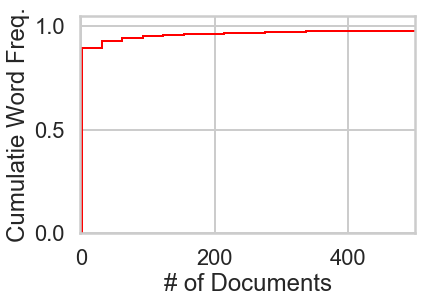

In [18]:
plt.hist(df_word_f.groupby(['freq']).size(),len(df_word_f['freq'].unique()),histtype='step',
         cumulative=1,normed=1,color='red',linewidth=2)
plt.xlim(-1, 500)
plt.xlabel('# of Documents')
plt.ylabel('Cumulatie Word Freq.')
plt.show()

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [19]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [20]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [21]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

Response:
What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?

We are trying to maximize the probability. For example, there may be two models that accurately predits a particular class for a given response, but, we would like to chose the model that gives the higher probability for that class.

 

Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?

$\alpha$ is a smoothing parameter, at its lowest value, there will be no smoothing, or the model will overfit the training data. If it is too high, the smoothing is going to be very high leading to lower accuracy

 

Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.



In [24]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
#min_dfs= [1,5,10,50,60,70,100] ## best 50
min_dfs=[0.00001,0.0001,0.0005,0.0008,0.001,0.003,0.005]#best 0.001
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for mindf in min_dfs:
    for alpha in alphas:        
        vectorizer = CountVectorizer(min_df=mindf)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
        print('alpha:',alpha,' min df:',mindf,' score:',score)
        if score>maxscore:
            maxscore=score
            best_alpha=alpha
            best_min_df=mindf
print('\n','best alpha:',best_alpha,'best min df:',best_min_df,' max score',maxscore)

alpha: 0.1  min df: 1e-05  score: -1001.1960226265998
alpha: 1  min df: 1e-05  score: -748.7749913860905
alpha: 5  min df: 1e-05  score: -1302.2730155003705
alpha: 10  min df: 1e-05  score: -1464.3779128710316
alpha: 50  min df: 1e-05  score: -1410.940830295189
alpha: 0.1  min df: 0.0001  score: -997.7361103612168
alpha: 1  min df: 0.0001  score: -640.7876886293275
alpha: 5  min df: 0.0001  score: -1032.0823624023149
alpha: 10  min df: 0.0001  score: -1263.0839261007068
alpha: 50  min df: 0.0001  score: -1355.5849699709613
alpha: 0.1  min df: 0.0005  score: -852.7686176637966
alpha: 1  min df: 0.0005  score: -591.0195381585961
alpha: 5  min df: 0.0005  score: -626.4429628763962
alpha: 10  min df: 0.0005  score: -808.8404279088384
alpha: 50  min df: 0.0005  score: -1166.1311495456223
alpha: 0.1  min df: 0.0008  score: -756.3563241022641
alpha: 1  min df: 0.0008  score: -580.8256728142816
alpha: 5  min df: 0.0008  score: -569.2168167906649
alpha: 10  min df: 0.0008  score: -682.773052761

In [25]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 0.001 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    clf = MultinomialNB(alpha=alpha)
    score = cv_score(clf,Xtrainthis,ytrainthis,log_likelihood)
    print('alpha:',alpha,'score:',score)
    if score>maxscore:
        maxscore=score
        best_alpha=alpha
print('\n','best alpha:',best_alpha,'max score',maxscore)
    # your turn

alpha: 0.1 score: -714.293334314784
alpha: 1 score: -575.6381462471551
alpha: 5 score: -556.9457400135652
alpha: 10 score: -642.9902224318477
alpha: 50 score: -1015.4054743246259

 best alpha: 5 max score -556.9457400135652


In [26]:
print("alpha: {}".format(best_alpha))

alpha: 5


In [27]:
logprob = clf.predict_log_proba(Xtrainthis)
prob = clf.predict_proba(Xtrainthis)
temp_pred_df=pd.DataFrame(clf.predict(Xtrainthis))
temp_pred_df.columns=['Prediction']
temp_pred_df['class0LogProb']=logprob[:,0]
temp_pred_df['class1LogProb']=logprob[:,1]
temp_pred_df['class0Prob']=prob[:,0]
temp_pred_df['class1Prob']=prob[:,1]

In [28]:
temp_pred_df[(temp_pred_df.Prediction==0)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
66,0,-0.635350,-0.754490,0.529750,0.470250
204,0,-0.685741,-0.700609,0.503717,0.496283
405,0,-0.495499,-0.939730,0.609267,0.390733
526,0,-0.603752,-0.791326,0.546757,0.453243
682,0,-0.672676,-0.714047,0.510341,0.489659
804,0,-0.683753,-0.702630,0.504719,0.495281
1189,0,-0.665882,-0.721176,0.513820,0.486180
1579,0,-0.622869,-0.768740,0.536403,0.463597
1822,0,-0.623680,-0.767803,0.535969,0.464031
2585,0,-0.576521,-0.825193,0.561850,0.438150


In [29]:
temp_pred_df[(temp_pred_df.Prediction==1)].head(10)

,Prediction,class0LogProb,class1LogProb,class0Prob,class1Prob
0,1,-2.112622,-0.128880,0.120920,0.879080
1,1,-2.574466,-0.079254,0.076195,0.923805
2,1,-2.383401,-0.096771,0.092236,0.907764
3,1,-7.828753,-0.000398,0.000398,0.999602
4,1,-3.610311,-0.027416,0.027043,0.972957
5,1,-4.636193,-0.009742,0.009695,0.990305
6,1,-2.161552,-0.122333,0.115146,0.884854
7,1,-2.876746,-0.057966,0.056318,0.943682
8,1,-4.559694,-0.010520,0.010465,0.989535
9,1,-0.970387,-0.476322,0.378936,0.621064


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

Response:
The accuracy of this classifier is less than the original model. However, this is less overfit than the original model

In [30]:
vectorizer = CountVectorizer(min_df=5)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print('min-df:',best_min_df)
print('alpha:',best_alpha)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

min-df: 0.001
alpha: 5
Accuracy on training data: 0.793103
Accuracy on test data:     0.698035


In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[1253 3013]
 [ 276 6350]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [33]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.87
               keeps 0.86
                rare 0.86
        entertaining 0.85
            touching 0.85
            stunning 0.84
            powerful 0.84
         performance 0.84
          experience 0.84
             perfect 0.83
Bad words	     P(fresh | word)
              boring 0.30
                save 0.30
               fails 0.30
          uninspired 0.29
              forced 0.29
                dull 0.28
             problem 0.23
             neither 0.23
                 nor 0.22
       unfortunately 0.22


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

This method builds a review with just one word and tries to classify the review based on that one word. The probability for each row gives the probability that the review will be classified as $fresh$ or $rotten$

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [34]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

Nava, who started his feature-film career with El Norte, is a good director who invariably finds a strong rapport with his actors. He's not much of a writer, though, and he should think twice about creating dialogue for his future projects.

Walt Disney started by making movies in which animated drawings played the parts of people or animals who stood for people. Later he turned to making movies in which people or animals play the parts of animated drawings.

In this film [Hughes] has created a character who is every teen-ager's fantasy, but in the process he has lost some of the authenticity of his other films.

With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that r

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

Response:
The given review should have been classified as $Rotten$, given what the critic has said about the movie. The critic has slammed the movie by saying that the movie is the opposite of all good things about a movie. However, the classifier has classified this as a $Fresh$ movie, because it contains a lot of Good words, or strong words that make the model classify the review as $Fresh$ 

In [35]:

#your turn
string = ['This movie is not remarkable, touching, or superb in any way']
x_test_q7 = vectorizer.transform(string)
print('Review -','\n',string,'\n')
if clf.predict(x_test_q7)[0]==1:
    print('predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7)[0,1]))
else:
    print('predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7)[0,0]))
print('---------------------------------','\n')
        
#lets check what happens if we include a lot of 'Bad' words like uninspired, bad, worst
string_another_review = ['This movie is uninspired, bad and has been the worst movie that i have ever seen']
x_test_q7_2 = vectorizer.transform(string_another_review)
print('Review -','\n',string_another_review,'\n')
if clf.predict(x_test_q7_2)[0]==1:
    print('predicted as Fresh with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7_2)[0,1]))
else:
    print('predicted as Rotten with a probability of  %2.2f' %(100*clf.predict_proba(x_test_q7_2)[0,0]))
print('---------------------------------','\n')

Review - 
 ['This movie is not remarkable, touching, or superb in any way'] 

predicted as Fresh with a probability of  98.78
--------------------------------- 

Review - 
 ['This movie is uninspired, bad and has been the worst movie that i have ever seen'] 

predicted as Fresh with a probability of  52.54
--------------------------------- 



### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [36]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment <b>(Optional)</b></h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try at least one of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result. 
</div>

In [38]:
def clf_score(clf, x, y):
    score = clf.score(x,y)
    return score

In [39]:

def find_good_bad_words(vctrzr,clfr):
    words = np.array(vctrzr.get_feature_names())
    x = np.eye(len(words))
    probs = clfr.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    print("Good words\t     P(fresh | word)")
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    print("Bad words\t     P(fresh | word)")
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Response:
Below is an implementation of Naive Bayes with n-grams.This uses 1,2 n-grams

In [40]:

# Your turn

from sklearn.naive_bayes import MultinomialNB

alphas = [1,5,10,50]
ngrm_min_df = [0,0.00009,0.0001,0.001,0.005,0.01]
best_score=-np.inf
best_alpha, best_min_df = None, None
for alpha in alphas:
    for min_df in ngrm_min_df:
        vectorizer_n2 = CountVectorizer(min_df=min_df,ngram_range=(1, 2),token_pattern=r'\b\w+\b')       
        #vectorizer_n2 = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer_n2)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
        print('alpha :',alpha,' min_df :',min_df,' score :',score)
        if score > best_score:
            best_score=score
            best_alpha = alpha
            best_min_df = min_df

print('-----------------')
print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

alpha : 1  min_df : 0  score : 0.6864389469166489
alpha : 1  min_df : 9e-05  score : 0.7292751387961286
alpha : 1  min_df : 0.0001  score : 0.7292751387961286
alpha : 1  min_df : 0.001  score : 0.7166429123891753
alpha : 1  min_df : 0.005  score : 0.660095567933791
alpha : 1  min_df : 0.01  score : 0.6470318628632282
alpha : 5  min_df : 0  score : 0.6226124656021996
alpha : 5  min_df : 9e-05  score : 0.6339631085742614
alpha : 5  min_df : 0.0001  score : 0.6339631085742614
alpha : 5  min_df : 0.001  score : 0.7087117378262197
alpha : 5  min_df : 0.005  score : 0.6618109251315666
alpha : 5  min_df : 0.01  score : 0.6476751791898758
alpha : 10  min_df : 0  score : 0.6144722074953352
alpha : 10  min_df : 9e-05  score : 0.6183279742765273
alpha : 10  min_df : 0.0001  score : 0.6183279742765273
alpha : 10  min_df : 0.001  score : 0.6669468982880854
alpha : 10  min_df : 0.005  score : 0.6598835007608254
alpha : 10  min_df : 0.01  score : 0.6474608169176358
alpha : 50  min_df : 0  score : 0.6

In [41]:
vectorizer_n2 = CountVectorizer(min_df=best_min_df,ngram_range=(1, 2),token_pattern=r'\b\w+\b')  
#vectorizer_n2 = CountVectorizer(min_df=0.001,ngram_range=(1, 2),token_pattern=r'\b\w+\b')  
#vectorizer_n2 = CountVectorizer(min_df=0.001)  
X, y = make_xy(critics, vectorizer_n2)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.972585
Accuracy on test data:     0.742104


In [42]:
find_good_bad_words(vectorizer_n2,clf)

Good words	     P(fresh | word)
            touching 0.96
            stunning 0.95
             to come 0.95
             film of 0.95
               witty 0.95
              honest 0.95
           the power 0.94
             delight 0.94
              a rare 0.94
            has made 0.94
Bad words	     P(fresh | word)
             problem 0.11
      disappointment 0.11
             none of 0.11
           pointless 0.11
             neither 0.11
            mediocre 0.11
              forced 0.10
          uninspired 0.10
                 nor 0.06
       unfortunately 0.06


Response:
Below is an implementation of Random Forest Classifier with n-grams.This uses 1,2 n-grams

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
mindfs=[0.00001,0.0005,0.0001,0.001]
#mindfs=[0.0005,0.0001]
for mindf in mindfs:
    vectorizer = CountVectorizer(min_df=mindf,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    Xtestthis = Xthis[~mask]
    ytestthis = ythis[~mask]
    feat=np.sqrt(len(vectorizer.get_feature_names()))
    parameters = {"n_estimators": [10,20,40,50,60,70],"max_features":['auto','sqrt','log2']}
    clf = RandomForestClassifier()
    fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
    fitmodel.fit(Xtrainthis, ytrainthis)
    print('-------min_df:',mindf)
    print('***best estimator:',fitmodel.best_estimator_)
    print('***best params:',fitmodel.best_params_)
    print('***best score:',fitmodel.best_score_)
    print('***grid scores:', fitmodel.grid_scores_)
    #score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
    #print(score)

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [ ]:
vectorizer = CountVectorizer(min_df=0.0005,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]
feat=np.sqrt(len(vectorizer.get_feature_names()))
parameters = {"n_estimators": [60,80,100,150,250],"max_features":['auto','sqrt','log2']}
clf = RandomForestClassifier()
fitmodel = GridSearchCV(clf, param_grid=parameters, scoring="accuracy")
fitmodel.fit(Xtrainthis, ytrainthis)
print('-------min_df:',mindf)
print('***best estimator:',fitmodel.best_estimator_)
print('***best params:',fitmodel.best_params_)
print('***best score:',fitmodel.best_score_)
print('***grid scores:', fitmodel.grid_scores_)

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
vectorizer = CountVectorizer(min_df=0.0005,ngram_range=(1, 2),token_pattern=r'\b\w+\b')
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]
Xtestthis = Xthis[~mask]
ytestthis = ythis[~mask]
clf = fitmodel.best_estimator_
score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
print(score)

In [ ]:
training_accuracy = clf.score(Xtrainthis, ytrainthis)
test_accuracy = clf.score(Xtestthis, ytestthis)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Response:
Below is an implementation of Naive Bayes that uses TF-IDF for classification

In [ ]:
:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=1).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [44]:
from sklearn.naive_bayes import MultinomialNB

alphas = [1,5,10,50]
min_dfs = [0,0.00009,0.0001,0.001,0.005,0.01]
#min_dfs = [0,0.00009,0.0001,0.001]
best_score=-np.inf
best_alpha,best_min_df = None,None

for alpha in alphas:
    for min_df in min_dfs:
        tfidfvectorizer = TfidfVectorizer(min_df=min_df,analyzer='word',stop_words='english',
                                          ngram_range=(1, 4),token_pattern=r'\b\w+\b')       
        #vectorizer_n2 = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, tfidfvectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf,Xtrainthis,ytrainthis,clf_score)
        print(' min_df :',min_df,'alpha:',alpha,' score :',score)
        if score > best_score:
            best_score=score
            best_min_df = min_df
            best_alpha = alpha

print('-----------------')
print('best alpha:',best_alpha,'best min-df:',best_min_df,'best score:',best_score)

 min_df : 0 alpha: 1  score : 0.6146863402576479
 min_df : 9e-05 alpha: 1  score : 0.6570963322018495
 min_df : 0.0001 alpha: 1  score : 0.6570963322018495
 min_df : 0.001 alpha: 1  score : 0.6973640784832147
 min_df : 0.005 alpha: 1  score : 0.640179155449369
 min_df : 0.01 alpha: 1  score : 0.6268971864377995
 min_df : 0 alpha: 5  score : 0.6116877930554887
 min_df : 9e-05 alpha: 5  score : 0.6129725896293644
 min_df : 0.0001 alpha: 5  score : 0.6129725896293644
 min_df : 0.001 alpha: 5  score : 0.6436011484676769
 min_df : 0.005 alpha: 5  score : 0.6373896917911184
 min_df : 0.01 alpha: 5  score : 0.6288243812986132
 min_df : 0 alpha: 10  score : 0.6116877930554887
 min_df : 9e-05 alpha: 10  score : 0.6116877930554887
 min_df : 0.0001 alpha: 10  score : 0.6116877930554887
 min_df : 0.001 alpha: 10  score : 0.619183128266213
 min_df : 0.005 alpha: 10  score : 0.6363174214100631
 min_df : 0.01 alpha: 10  score : 0.6266819061258495
 min_df : 0 alpha: 50  score : 0.6116877930554887
 min

In [45]:
tfidfvectorizer = TfidfVectorizer(min_df=best_min_df,analyzer='word',stop_words='english',
                                  ngram_range=(1, 4),token_pattern=r'\b\w+\b')
#Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.808738
Accuracy on test data:     0.709144


In [46]:
find_good_bad_words(tfidfvectorizer,clf)

Good words	     P(fresh | word)
         masterpiece 0.93
            touching 0.91
               witty 0.90
              honest 0.89
            stunning 0.89
               keeps 0.89
             delight 0.89
                rare 0.89
        entertaining 0.88
             perfect 0.88
Bad words	     P(fresh | word)
          simplistic 0.21
              boring 0.20
                dull 0.19
      disappointment 0.17
            mediocre 0.17
              forced 0.17
          uninspired 0.17
           pointless 0.16
             problem 0.13
       unfortunately 0.13


Response:
Below is an implementation of LDA for classification

In [47]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
vectorizer_lda = CountVectorizer(min_df=0.00009,ngram_range=(1, 2),token_pattern=r'\b\w+\b') 

X, y = make_xy(critics, vectorizer_lda)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

In [48]:
lda = LDA(n_topics=20)
lda.fit(xtrain)
training_features = lda.transform(xtrain)
testing_features=lda.transform(xtest)
xtrain_trn_feat=sp.sparse.hstack((xtrain,sp.sparse.csc_matrix(training_features)))
xtest_tst_feat=sp.sparse.hstack((xtest,sp.sparse.csc_matrix(testing_features)))

#clf = MultinomialNB(alpha=1).fit(xtrain_trn_feat, ytrain)

TypeError: __init__() got an unexpected keyword argument 'n_topics'

In [49]:
clf = MultinomialNB(alpha=1).fit(xtrain_trn_feat, ytrain)
#clf = MultinomialNB(alpha=5).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain_trn_feat, ytrain)
test_accuracy = clf.score(xtest_tst_feat, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

NameError: name 'xtrain_trn_feat' is not defined